In [1]:
import csv
from datetime import timedelta
import gurobipy as gp 
from gurobipy import GRB
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def hhmm2mins(hhmm):
    h, m = map(int, hhmm.split(':'))
    return h*60 + m

def mins2hhmm(mins):
    h = mins // 60
    m = mins % 60
    return f"{h:02}:{m:02}"

In [3]:
class Service:
    def __init__(self, attrs):
        self.serv_num = int(attrs[0])
        self.train_num = attrs[1]
        self.start_stn = attrs[2]
        self.start_time = hhmm2mins(attrs[3])
        self.end_stn = attrs[4]
        self.end_time = hhmm2mins(attrs[5])
        self.direction = attrs[6]
        self.serv_dur = int(attrs[7])
        self.jurisdiction = attrs[8]
        self.stepback_train_num = attrs[9]
        self.serv_added = False
        self.break_dur = 0
        self.trip_dur = 0

In [4]:
def fetch_data(filename):
    services = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            services.append(Service(row))
    return services

In [5]:
def draw_graph(graph, n=50):
    # Create a new subgraph containing only the first n edges
    subgraph = nx.Graph()
    
    # Add the first n edges and associated nodes to the subgraph
    edge_count = 0
    for u, v in graph.edges():
        if edge_count >= n:
            break
        subgraph.add_edge(u, v)
        edge_count += 1

    # Plotting the subgraph
    plt.figure(figsize=(12,12))
    pos = nx.spring_layout(subgraph)  # Position nodes using the spring layout
    nx.draw(subgraph, pos, with_labels=True, node_size=10, font_size=8, edge_color='blue', node_color='red')
    plt.title(f"First {n} Edges of the Network")
    # plt.show()
    plt.savefig(f'first{n}edges.png')


In [6]:
## checking if two services can be connected

def node_legal(service1, service2):
    if service1.stepback_train_num == "No Stepback":
        if service2.train_num == service1.train_num:
            if service1.end_stn == service2.start_stn and 0 <= (service2.start_time - service1.end_time) <= 15:
                return True
        else:
            if (service1.end_stn[:4] == service2.start_stn[:4]) and (service2.start_time >= service1.end_time + 30) and (service2.start_time <= service1.end_time + 150):
                return True
        
    else:
        if service2.train_num == service1.stepback_train_num:
            if (service1.end_stn == service2.start_stn) and (service1.end_time == service2.start_time):
                return True
        else:
            if (service1.end_stn[:4] == service2.start_stn[:4]) and (service2.start_time >= service1.end_time + 30 ) and (service2.start_time <= service1.end_time + 150):
                return True
    return False

In [7]:
# Define the condition for no overlap between two services
def no_overlap(service1, service2):
    return service1.end_time <= service2.start_time

# Step 1: Create the network of duties
def create_duty_graph(services):
    G = nx.DiGraph()

    for i, service1 in enumerate(services):
        G.add_node(service1.serv_num)

    for i, service1 in enumerate(services):
        for j, service2 in enumerate(services):
            if i != j:
                if node_legal(service1, service2):
                    G.add_edge(service1.serv_num, service2.serv_num)
    
    return G

# Check if a service can be appended to a duty
def can_append(duty, service):
    last_service = duty[-1]
    
    start_end_stn_tf = last_service.end_stn == service.start_stn
    # print(service.start_time, last_service.end_time)
    start_end_time_tf = 5 <= (service.start_time - last_service.end_time) <= 15
    start_end_stn_tf_after_break = last_service.end_stn[:4] == service.start_stn[:4]
    start_end_time_within = 50 <= (service.start_time - last_service.end_time) <= 150

    if last_service.stepback_train_num == "No StepBack":
        start_end_rake_tf = last_service.train_num == service.train_num
    else:
        start_end_rake_tf = last_service.stepback_train_num == service.train_num
    
    # Check for valid conditions and time limits
    if start_end_rake_tf and start_end_stn_tf and start_end_time_tf:
        time_dur = service.end_time - duty[0].start_time
        cont_time_dur = sum([serv.serv_dur for serv in duty])
        if cont_time_dur <= 180 and time_dur <= 445:
            return True
    elif start_end_time_within and start_end_stn_tf_after_break:
        time_dur = service.end_time - duty[0].start_time
        if time_dur <= 445:
            return True
    return False

# Step 2: Get an initial feasible solution by forming duties
def initial_feasible_solution(services):
    duties = []
    for service in services:
        if not service.serv_added:
            duty = [service]
            service.serv_added = True

            for unadded_service in services:
                if not unadded_service.serv_added and can_append(duty, unadded_service):
                    duty.append(unadded_service)
                    unadded_service.serv_added = True

            duties.append([s.serv_num for s in duty])
    return duties


# with Farkas pricing
def solving_RMLP_art_vars(services, duties):
    objective = 0
    model = gp.Model("CrewScheduling")
    
    duty_vars = []
    for i in range(len(duties)):
        duty_vars.append(model.addVar(vtype=GRB.CONTINUOUS,ub=1, lb=0, name=f"x{i}"))

    big_penalty = 1e6
    artifical_vars = []
    for i in range(len(services)):
        artifical_vars.append(model.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, obj=big_penalty, name=f"artifical_{i}"))

    model.setObjective(gp.quicksum(duty_vars) + gp.quicksum(artifical_vars), GRB.MINIMIZE)

    service_constraints = []
    for service_idx, service in enumerate(services):
        constr = model.addConstr(
            gp.quicksum(duty_vars[duty_idx] for duty_idx, duty in enumerate(duties) if service.serv_num in duty) + artifical_vars[service_idx] >= 1,
            name=f"Service_{service.serv_num}")
        service_constraints.append(constr)

    model.optimize()

    if model.status == GRB.INFEASIBLE:
        print('infeasible h gadhe')
    if model.status == GRB.OPTIMAL:
        objective = model.getObjective()
        print("Optimal solution found (with artificial variables)!")
        dual_values = [constr.Pi for constr in service_constraints]  # Pi gives the dual variables
        selected_duties = [v.varName for v in model.getVars() if v.x > 0.5 and "artificial" not in v.varName]
        
        # Check how many artificial variables are in use
        artificial_in_use = [v.varName for v in artifical_vars if v.x > 0.5]
        print(f"Artificial variables in use: {artificial_in_use}")
        return selected_duties, dual_values, artificial_in_use, int(objective.getValue())
    else:
        print("No optimal solution found.")
        return None, None, None, None


In [8]:
services = fetch_data('StepBackServices.csv')
graph = create_duty_graph(services)
duties = initial_feasible_solution(services)
selected_duties, duals, artificial_vars, obj = solving_RMLP_art_vars(services, duties[:10])

Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 934 rows, 944 columns and 982 nonzeros
Model fingerprint: 0x2388ec4e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 886 rows and 886 columns
Presolve time: 0.02s
Presolved: 48 rows, 58 columns, 96 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.8600000e+02   4.800000e+01   0.000000e+00      0s
      20    8.9600000e+02   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.03 seconds (0.00 work units)
Optimal objective  8.960000000e+02
Optimal solution found (with artificial v

DiGraph with 934 nodes and 31674 edges


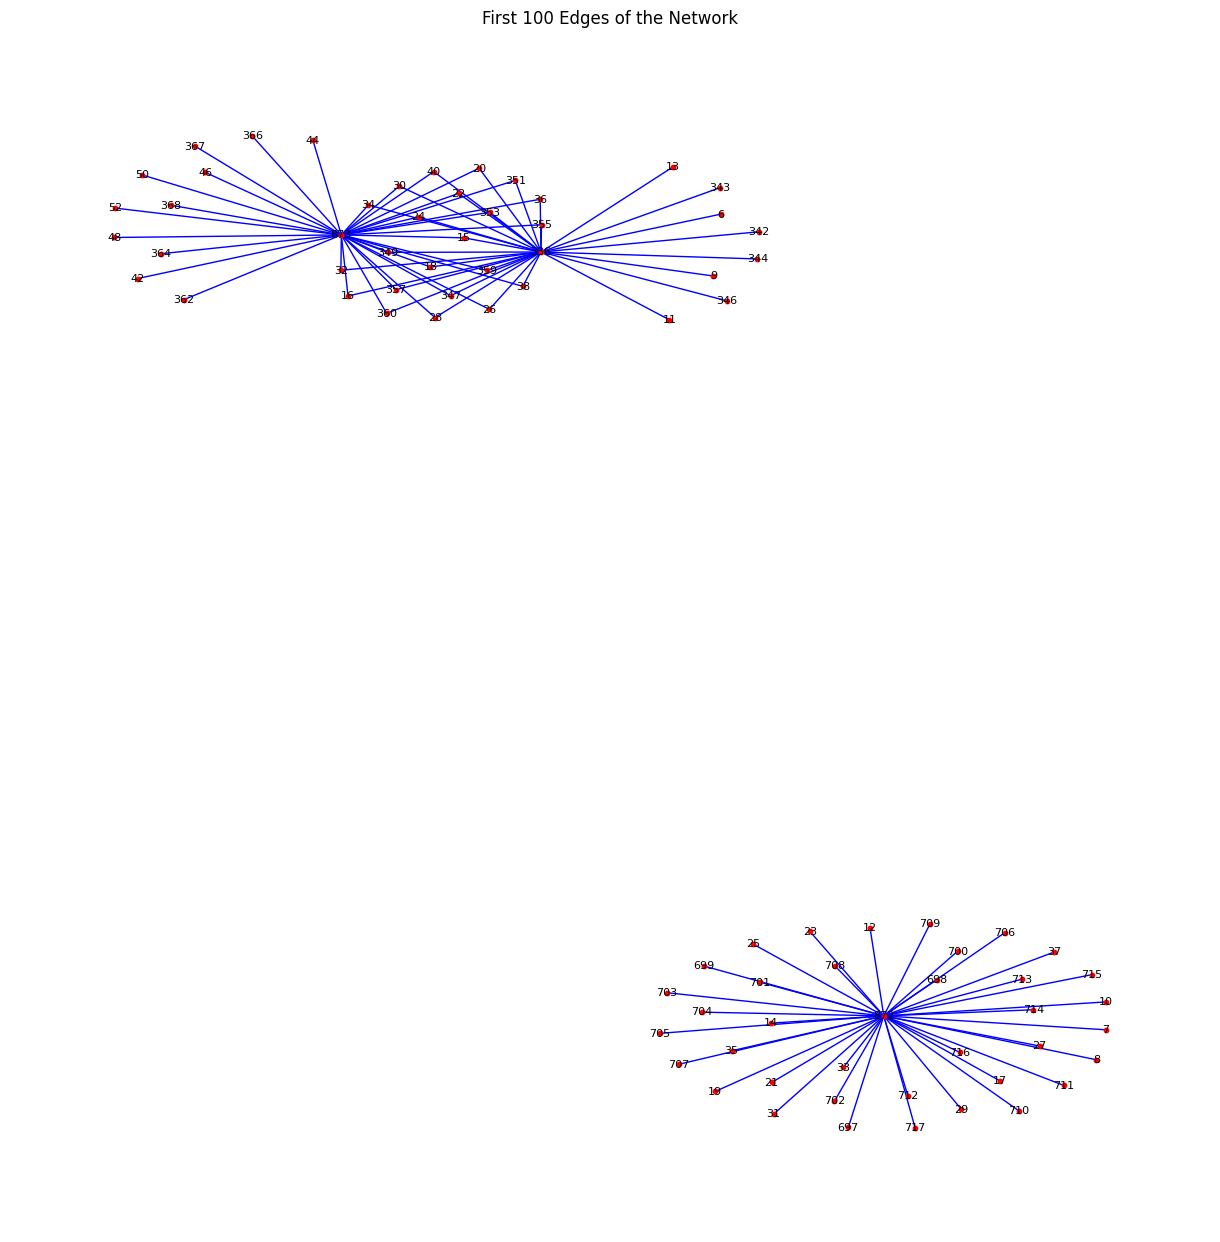

In [9]:
draw_graph(graph, n=100)
print(graph)

In [10]:
def generate_initial_feasible_duties(G, services, num_duties):
    feasible_duties = []
    duties_generated = 0 
    
    def build_duty(duty):
        nonlocal duties_generated
        
        if num_duties is not None and duties_generated >= num_duties:
            return

        last_service = duty[-1]
        for successor in G.successors(last_service.serv_num):
            next_service = next(service for service in services if service.serv_num == successor)
            if can_append(duty, next_service):
                new_duty = duty + [next_service]  # Create a new duty by adding the next service
                feasible_duties.append(new_duty)  # Store the valid duty
                duties_generated += 1  # Increment the counter
                
                if num_duties is not None and duties_generated >= num_duties:
                    return  # Stop if we've generated enough duties
                
                build_duty(new_duty)  # Recursively extend the duty if possible

    # Start building duties from each service
    for service in services:
        if num_duties is not None and duties_generated >= num_duties:
            break  # Stop generating duties if we've reached the required number

        initial_duty = [service]  # Start with each service as a separate duty
        feasible_duties.append(initial_duty)
        duties_generated += 1  # Increment the counter
        
        if num_duties is not None and duties_generated >= num_duties:
            break  # Stop generating duties if we've reached the required number
        
        build_duty(initial_duty)  # Recursively build duties from this starting point

    return feasible_duties

In [11]:
feasible_duties = generate_initial_feasible_duties(graph, services, 200)
feasible_duties_2 = []
for duty in feasible_duties:
    tt = []
    for service in duty:
        tt.append(service.serv_num)
    feasible_duties_2.append(tt)
selected_duties, duals, art_vars, obj = solving_RMLP_art_vars(services, feasible_duties_2)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 934 rows, 1137 columns and 1886 nonzeros
Model fingerprint: 0xb2363b33
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 861 rows and 862 columns
Presolve time: 0.02s
Presolved: 73 rows, 275 columns, 1024 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.6100000e+02   7.300000e+01   0.000000e+00      0s
     135    9.1100000e+02   0.000000e+00   0.000000e+00      0s

Solved in 135 iterations and 0.04 seconds (0.00 work units)
Optimal objective  9.110000000e+02
Optimal solution found (with artificial variables)!
Artificial variables in use: ['artifical_1', 'artific

In [12]:
print(len(feasible_duties_2),"+", len(art_vars), len(selected_duties))

203 + 890 911


In [13]:
objectives = []
for i in range(10, 700, 40):
    feasible_duties = generate_initial_feasible_duties(graph, services, i)
    feasible_duties_2 = []
    for duty in feasible_duties:
        tt = []
        for service in duty:
            tt.append(service.serv_num)
        feasible_duties_2.append(tt)
    selected_duties, duals, artificial_vars, obj = solving_RMLP_art_vars(services, feasible_duties_2)
    objectives.append(obj)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 934 rows, 947 columns and 983 nonzeros
Model fingerprint: 0xa282caa8
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 921 rows and 922 columns
Presolve time: 0.01s
Presolved: 13 rows, 25 columns, 61 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.2100000e+02   1.300000e+01   0.000000e+00      0s
      17    9.3000000e+02   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.300000000e+02
Optimal solution found (with artificial variables)!
Artificial variables in use: ['artifical_1', 'artifical_2',

903


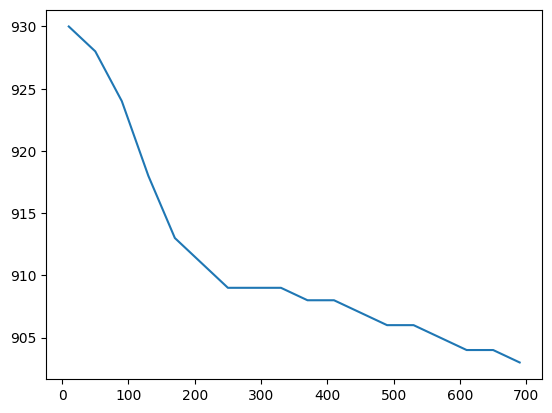

In [14]:
x = [i for i in range(10, 700, 40)]
plt.plot(x, objectives)
plt.savefig('num_initial_duties_vs_objective.png')
print(min(objectives))

In [21]:
def solve_pricing_problem(duties, dual_values, graph):
    new_duties = []
    reduced_costs = []

    for duty_idx, duty in enumerate(duties):
        # Compute the reduced cost for each duty
        duty_cost = 1  # Assuming cost of each duty is 1 (or replace with actual cost if provided)
        
        # Calculate the dual contribution to the reduced cost
        dual_contribution = sum(dual_values[service_idx] for service_idx in graph[duty_idx])

        # Reduced cost formula
        reduced_cost = duty_cost - dual_contribution
        reduced_costs.append(reduced_cost)

        # If the reduced cost is negative, this duty should be added to the RMLP
        if reduced_cost < 0:
            new_duties.append(duty)

    print(f"Duties with negative reduced cost: {new_duties}")
    return new_duties, reduced_costs


def solving_RMLP_art_vars_final(services, graph):
    objective = 0
    model = gp.Model("CrewScheduling")
    model.setParam('OutputFlag', 0)
    
    # Step 1: Define the decision variables
    duty_vars = []
    for i in range(len(duties)):
        duty_vars.append(model.addVar(vtype=GRB.CONTINUOUS, ub=1, lb=0, name=f"x{i}"))

    big_penalty = 1e6
    artifical_vars = []
    for i in range(len(services)):
        artifical_vars.append(model.addVar(vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, obj=big_penalty, name=f"artifical_{i}"))

    # Step 2: Set the objective function
    model.setObjective(gp.quicksum(duty_vars) + gp.quicksum(artifical_vars), GRB.MINIMIZE)

    # Step 3: Add service constraints
    service_constraints = []
    for service_idx, service in enumerate(services):
        constr = model.addConstr(
            gp.quicksum(duty_vars[duty_idx] for duty_idx, duty in enumerate(duties) if service.serv_num in duty) + artifical_vars[service_idx] >= 1,
            name=f"Service_{service.serv_num}")
        service_constraints.append(constr)

    model.optimize()

    # Step 4: Check the solution and retrieve dual values
    if model.status == GRB.INFEASIBLE:
        print('Infeasible problem!')
    elif model.status == GRB.OPTIMAL:
        objective = model.getObjective()
        print("Optimal solution found (with artificial variables)!")
        
        # Get the dual variables for each service constraint
        dual_values = [constr.Pi for constr in service_constraints]  # Pi gives the dual variables
        
        selected_duties = [v.varName for v in model.getVars() if v.x > 0.5 and "artificial" not in v.varName]
        
        # Check how many artificial variables are in use
        artificial_in_use = [v.varName for v in artifical_vars if v.x > 0.5]
        # print(f"Artificial variables in use: {artificial_in_use}")
        
        # Step 5: Solve the pricing problem to find new duties with negative reduced cost
        new_duties, reduced_costs = solve_pricing_problem(services, dual_values, graph)
        
        return selected_duties, dual_values, artificial_in_use, int(objective.getValue()), new_duties
    else:
        print("No optimal solution found.")
        return None, None, None, None, None

In [22]:
def column_generation(services, initial_duties, graph):
    duties = initial_duties  # Start with the initial set of duties
    converged = False
    iteration = 0

    while not converged:
        print(f"--- Iteration {iteration} ---")

        # Step 1: Solve the RMLP with the current set of duties
        selected_duties, dual_values, artificial_in_use, obj_value, new_duties = solving_RMLP_art_vars_final(services, graph)
        print("number of artificial variables are: ", len(artificial_in_use))
        
        # Step 2: If there are new duties from the pricing problem, add them to the duty list
        if new_duties != []:
            print(f"Adding {len(new_duties)} new duties to the RMLP")
            duties.append(new_duties)  # Add new duties (columns) to the RMLP
            print("new number of duties are: ", len(duties))
            print("new variables added are: ", duties[-3:])
            
            # Continue to the next iteration since we found new duties
            iteration += 1
        else:
            # No new duties with negative reduced cost, meaning the solution has converged
            converged = True
            print("Column generation has converged!")
    
    # Step 3: Final solution with selected duties
    final_solution = selected_duties
    return final_solution


In [23]:
initial_dooties = generate_initial_feasible_duties(graph, services, 17)
initial_dooties_2 = []
for duty in initial_dooties:
    tt = []
    for service in duty:
        tt.append(service.serv_num)
    initial_dooties_2.append(tt)
# final_sol = column_generation(services, initial_dooties_2, graph)
selected_duties, dual_values, artificial_in_use, obj_value, new_duties, new_costs = solving_RMLP_art_vars_final(services, graph)
# print(len(initial_dooties))

Optimal solution found (with artificial variables)!
Duties with negative reduced cost: [<__main__.Service object at 0x000001D5FB9AA660>, <__main__.Service object at 0x000001D5FA8B0380>, <__main__.Service object at 0x000001D5FB9AA450>, <__main__.Service object at 0x000001D5FB9AAD80>, <__main__.Service object at 0x000001D5FB9AADB0>, <__main__.Service object at 0x000001D5FB9AA750>, <__main__.Service object at 0x000001D5FB9AA810>, <__main__.Service object at 0x000001D5FB9AA270>, <__main__.Service object at 0x000001D5FB9AAA80>, <__main__.Service object at 0x000001D5FB9AA150>, <__main__.Service object at 0x000001D5FB9AAC60>, <__main__.Service object at 0x000001D5FB9AAE10>, <__main__.Service object at 0x000001D5FB9AAF00>, <__main__.Service object at 0x000001D5FB9AAFF0>, <__main__.Service object at 0x000001D5FB9AB260>, <__main__.Service object at 0x000001D5FB9AB1A0>, <__main__.Service object at 0x000001D5FB9AB2F0>, <__main__.Service object at 0x000001D5FB9AB380>, <__main__.Service object at 0x

ValueError: not enough values to unpack (expected 6, got 5)

In [ ]:
column_generation(services, initial_dooties_2, graph)